In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
TRAIN_PATH = "./data/train/"
imgnames = [filename for filename in os.listdir(TRAIN_PATH)]


In [3]:
csv_path = "./data/train.csv"
df = pd.read_csv(csv_path)
# df = df.dropna().reset_index(drop=True)
df.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [4]:
file_df = df["ImageId_ClassId"].str.split("_", expand=True).rename(
    columns={0:"ImageId", 1:"class"})
new_df = pd.merge(file_df, df, right_index=True, left_index=True)[
    ["ImageId", "class", "EncodedPixels"]]
new_df.head()

,ImageId,class,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg,2,NaN
2,0002cc93b.jpg,3,NaN
3,0002cc93b.jpg,4,NaN
4,00031f466.jpg,1,NaN


In [5]:
new_df.iloc[1,2]

nan

In [6]:
def rle_to_pixels(str_rle):
    pixels = []
    if str_rle is not np.nan:
        result = [int(value) for value in str_rle.split(" ")]
        result_list = np.array(result).reshape(-1,2).tolist()
        for start, end in result_list:
            pixels.extend(list(range(start-1, start+end-1)))
    return pixels

In [7]:
new_df["list_pixels"] = new_df.EncodedPixels.map(rle_to_pixels)

In [8]:
len(new_df.ImageId.unique())

12568

In [9]:
def rle_to_mask(filepath, df):
    img = cv2.imread(filepath)
    height, width, channel = img.shape
    mask = np.zeros((width,height), dtype=np.int16).flatten()
    for index, rows in df.iterrows(): 
        mask[rows["list_pixels"]] = rows["class"]
    return np.stack( (mask.reshape(width,height).T,) * 3, axis=-1) 

In [10]:
filepath_dict = {filename : os.path.join(TRAIN_PATH,filename) for filename in imgnames}
result = rle_to_mask(filepath_dict["0025bde0c.jpg"], new_df[new_df["ImageId"] == "0025bde0c.jpg"])

KeyError: '0025bde0c.jpg'

In [ ]:
new_df[new_df["ImageId"] == "0025bde0c.jpg"]

In [11]:
from data_utils.data_loader import \
    get_pairs_from_paths, DATA_LOADER_SEED, class_colors, DataLoaderError


Error in loading augmentation, can't import imgaug. Please make sure it is installed.


In [12]:
def _get_colored_segmentation_image( seg, colors, n_classes, do_augment=False):
    """ Return a colored segmented image """
    seg_img = np.zeros_like(seg)

    for c in range(n_classes):
        seg_img[:, :, 0] += ((seg[:, :, 0] == c) *
                            (colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg[:, :, 0] == c) *
                            (colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg[:, :, 0] == c) *
                            (colors[c][2])).astype('uint8')

    return seg_img

In [13]:
new_df[new_df["ImageId"] == "0014fce06.jpg"]

,ImageId,class,EncodedPixels,list_pixels
28,0014fce06.jpg,1,NaN,[]
29,0014fce06.jpg,2,NaN,[]
30,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,"[229500, 229501, 229502, 229503, 229504, 22950..."
31,0014fce06.jpg,4,NaN,[]


In [14]:
result = rle_to_mask(filepath_dict["0025bde0c.jpg"], 
                     new_df[new_df["ImageId"] == "0025bde0c.jpg"])
new_seg = _get_colored_segmentation_image(result, class_colors, 11)
plt.imshow(new_seg, interpolation='nearest')
plt.show()

KeyError: '0025bde0c.jpg'

In [15]:
resize_seg = cv2.resize(cv2.resize(new_seg, (256,256)), (1600, 256))
plt.imshow(resize_seg, interpolation='nearest')
plt.show()                        

NameError: name 'new_seg' is not defined

In [16]:
filepath = filepath_dict["0025bde0c.jpg"]
img = cv2.imread(filepath)
plt.imshow(img, interpolation='nearest')
plt.show()

KeyError: '0025bde0c.jpg'

In [17]:
import os
import tensorflow as tf
from  tensorflow.keras import models

In [18]:
model_filepath = os.path.join(
    "model_repo", "unet_256_model.json"
)
# Reload the model from the json file
with open(model_filepath) as json_file:
    json_config = json_file.read()
model = models.model_from_json(json_config)

In [19]:
high_accuracy_weight_path = os.path.join("weights", "best_weights.hdf5")
model.load_weights(high_accuracy_weight_path)


In [20]:
TRAIN_PATH = "./data/train/images"
imgnames = [filename for filename in os.listdir(TRAIN_PATH)]
image_path = [os.path.join(TRAIN_PATH, img_name) for img_name in imgnames]

In [21]:
def get_npy(filelist):
    BASE_SIZE = 256
    result = []
    for filename in filelist:
        img = cv2.imread(filename)
        img = cv2.resize(img, (BASE_SIZE, BASE_SIZE))
        result.append(img)    
    return np.array(result)

In [22]:
batch_img = get_npy(image_path[:4])
result = model.predict(batch_img)
result_one = result[0].argmax(axis=2)
stacked_img = np.stack((result_one,)*3, axis=-1)


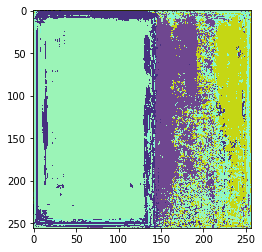

In [36]:
from data_utils.data_loader import \
    get_pairs_from_paths, DATA_LOADER_SEED, class_colors, DataLoaderError
stacked_img = np.stack((result_one,)*3, axis=-1)
new_seg = _get_colored_segmentation_image(stacked_img, class_colors, 11)
# new_seg = cv2.resize(new_seg,dsize=(1600, 256), interpolation=cv2.INTER_CUBIC)
plt.imshow(new_seg, interpolation='nearest')
plt.show()

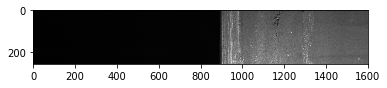

In [42]:
img = cv2.imread(image_path[0])
plt.imshow(img, interpolation='nearest')
plt.show()

In [47]:
MASK_PATH = "./data/train/mask"
filepath= os.path.join(
    MASK_PATH, image_path[0].split("/")[-1].split(".")[0]+".png")

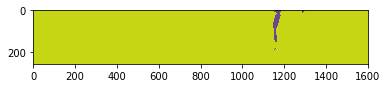

In [49]:
img = cv2.imread(filepath)
new_seg = _get_colored_segmentation_image(img, class_colors, 11)
# new_seg = cv2.resize(new_seg,dsize=(1600, 256), interpolation=cv2.INTER_CUBIC)
plt.imshow(new_seg, interpolation='nearest')
plt.show()
